In [2]:
# YouTube API 데이터 추출 후 JSON 저장
import json
import pandas as pd
import googleapiclient.discovery
from dotenv import dotenv_values


def get_api_key():
    ''' 
    Youtube API Key
    '''
    config = dotenv_values(".env")
    return config['API_KEY']


def get_data(count=999999, nextPageToken=""):
    '''
    Change YOUR_API_KEY!!!
    Recursively receive data as much as maxResults through API. 
    Limit API calls to count parameter.
    '''
    # Check count
    if count < 1:
        print("[INFO] Count End.")
        return

    # Disable OAuthlib's HTTPS verification when running locally.
    # *DO NOT* leave this option enabled in production.
    # os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

    api_service_name = "youtube"
    api_version = "v3"
    DEVELOPER_KEY = get_api_key()  # "YOUR_API_KEY"

    youtube = googleapiclient.discovery.build(
        api_service_name, api_version, developerKey=DEVELOPER_KEY)

    # Document reference
    # example >> part="id, snippet, replies", maxResults=20, order="relevance", pageToken=nextPageToken, videoId="HNObBsbvxOk",
    request = youtube.commentThreads().list(
        part="id, snippet, replies",
        maxResults=100,
        order="relevance",
        pageToken=nextPageToken,
        videoId="PQsaqGcloBY",
    )
    response = request.execute()

    print(f"************** {count} times left. **************")

    # with open('data/popular_game_10.json', 'w', encoding="utf-8") as make_file:
    #     json.dump(response, make_file, indent="\t", ensure_ascii=False)
    #     print("[INFO] Saved.")

    # print(response)

    # Call recursive when nextPageToken is exist.
    if "nextPageToken" in response:
        get_data(count-1, response["nextPageToken"])
    else:
        print("[End] No more comments.")


get_data(1)
print("[INFO] Finished.")

In [3]:
# JSON 데이터에서 원하는 정보만 추출하여 pandas 후 csv로 저장
import pandas as pd
import json

num = 10
category = "popular_new_"
src = "data/" + category + str(num) + ".json"
dst = "data/csv/" + category + str(num) + ".csv"


def open_json_file():

    with open(src, "r", encoding="utf-8") as f:
        json_data = json.load(f)
    return json_data


json_data = open_json_file()
items = json_data["items"]

videoId = []
item_type = []  # 0: comment, 1: replie
textDisplay = []
textOriginal = []
authorDisplayName = []
authorChannelUrl = []
likeCount = []
# isBad = []

for item in items:
    comment_videoId = item["snippet"]["videoId"]
    comment_textDisplay = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
    comment_textOriginal = item["snippet"]["topLevelComment"]["snippet"]["textOriginal"]
    comment_authorDisplayName = item["snippet"]["topLevelComment"]["snippet"]["authorDisplayName"]
    comment_authorChannelUrl = item["snippet"]["topLevelComment"]["snippet"]["authorChannelUrl"]
    comment_likeCount = item["snippet"]["topLevelComment"]["snippet"]["likeCount"]
    comment_totalReplyCount = item["snippet"]["totalReplyCount"]

    videoId.append(comment_videoId)
    item_type.append(0)
    textDisplay.append(comment_textDisplay)
    textOriginal.append(comment_textOriginal)
    authorDisplayName.append(comment_authorDisplayName)
    authorChannelUrl.append(comment_authorChannelUrl)
    likeCount.append(comment_likeCount)

    if comment_totalReplyCount != 0:
        replies = item["replies"]["comments"]

        for replie in replies:
            replie_videoId = replie["snippet"]["videoId"]
            replie_textDisplay = replie["snippet"]["textDisplay"]
            replie_textOriginal = replie["snippet"]["textOriginal"]
            replie_authorDisplayName = replie["snippet"]["authorDisplayName"]
            replie_authorChannelUrl = replie["snippet"]["authorChannelUrl"]
            replie_likeCount = replie["snippet"]["likeCount"]

            videoId.append(replie_videoId)
            item_type.append(1)
            textDisplay.append(replie_textDisplay)
            textOriginal.append(replie_textOriginal)
            authorDisplayName.append(replie_authorDisplayName)
            authorChannelUrl.append(replie_authorChannelUrl)
            likeCount.append(replie_likeCount)

data = {'videoId': videoId, 'item_type': item_type, 'authorDisplayName': authorDisplayName,
        'textDisplay': textDisplay, 'textOriginal': textOriginal, 'authorChannelUrl': authorChannelUrl, 'likeCount': likeCount}

df = pd.DataFrame(data)
df["isBad"] = 0
df.to_csv(dst)
df

,videoId,item_type,authorDisplayName,textDisplay,textOriginal,authorChannelUrl,likeCount,isBad
0,EB2wH1_B_7A,0,뇌피소설가 입소문tv,ㅇㄹㅈㅂㅅㅎㅈ 초성정답,ㅇㄹㅈㅂㅅㅎㅈ 초성정답,http://www.youtube.com/channel/UChpiLQ5R0TYR9O...,65,0
1,EB2wH1_B_7A,1,안용호,오 예측성공,오 예측성공,http://www.youtube.com/channel/UCsgdLLQoAN5RoY...,0,0
2,EB2wH1_B_7A,1,경이로운 쿠키,이거 17회에요,이거 17회에요,http://www.youtube.com/channel/UCis3ExhHkhEvJE...,0,0
3,EB2wH1_B_7A,1,까페모카,아아~,아아~,http://www.youtube.com/channel/UCpcR4qXlzGEAZs...,1,0
4,EB2wH1_B_7A,1,이민호,지하 금불상...딜 아닐까요?,지하 금불상...딜 아닐까요?,http://www.youtube.com/channel/UCaFvZHUQn-S5OX...,3,0
...,...,...,...,...,...,...,...,...
166,EB2wH1_B_7A,0,강신조,인터폴이 훼이크,인터폴이 훼이크,http://www.youtube.com/channel/UCFocoqPhfHroXu...,0,0
167,EB2wH1_B_7A,0,경이로운 쿠키,18회예상해봤을때는 장한서랑 빈센조랑 짜고 총을쏘는 척 을 한다음 빈센조가 병원에 ...,18회예상해봤을때는 장한서랑 빈센조랑 짜고 총을쏘는 척 을 한다음 빈센조가 병원에 ...,http://www.youtube.com/channel/UCis3ExhHkhEvJE...,1,0
168,EB2wH1_B_7A,0,ej RYU,잘 봤어요~ 감사합니다,잘 봤어요~ 감사합니다,http://www.youtube.com/channel/UC9kpxtJ5PMjnBZ...,0,0
169,EB2wH1_B_7A,0,임요셉,ㄹㅇ 빼박임 ㅋㅋㅋㅎㅎㅋㅋㅋㅎㅋ 작가 의도가 너무 뻔함 물론 내 눈엔,ㄹㅇ 빼박임 ㅋㅋㅋㅎㅎㅋㅋㅋㅎㅋ 작가 의도가 너무 뻔함 물론 내 눈엔,http://www.youtube.com/channel/UCugBqPM8RrWeRI...,0,0


In [ ]:
# 인기동영상 모두 병합
import pandas as pd

data = []

for i in range(1, 11):
    path = "data/csv/popular_new_" + str(i) + ".csv"
    df = pd.read_csv(path)
    data.append(df)

finalDf = pd.concat(data)
finalDf.to_csv("data/csv/popular_new_sum.csv")

In [6]:
import pandas as pd
df = pd.read_csv("data/csv/popular_final_sum.csv")
df

,Unnamed: 0,videoId,item_type,authorDisplayName,textDisplay,textOriginal,authorChannelUrl,likeCount,category,isBad
0,0,K7qKmZn0XfE,0,big k,힘든시기. 연우 하영이<br />보는재미에 푹 빠져<br />잘 지냈습니다<br /...,힘든시기. 연우 하영이\n보는재미에 푹 빠져\n잘 지냈습니다\n그동안 고생많이. 하...,http://www.youtube.com/channel/UCjDN0NP-BJ1WEP...,151.0,new,0.0
1,1,K7qKmZn0XfE,1,미션페이,제 체널에서 무료로 돈버세요~^^,제 체널에서 무료로 돈버세요~^^,http://www.youtube.com/channel/UCXk7WVpUdr9In1...,0.0,new,1.0
2,2,K7qKmZn0XfE,0,임충희,경완님 그동안 많이 고마웠어요<br />항상 행복하시고 연우 하영이 모습 자주보여주...,경완님 그동안 많이 고마웠어요\n항상 행복하시고 연우 하영이 모습 자주보여주세요.\...,http://www.youtube.com/channel/UCajvtubq_aEsGh...,669.0,new,0.0
3,3,K7qKmZn0XfE,1,과연 퀴즈,구독안하면 영원히 솔로,구독안하면 영원히 솔로,http://www.youtube.com/channel/UCA8pGSJzLLhRtk...,5.0,new,1.0
4,4,K7qKmZn0XfE,0,김남이,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,언제나 응원합니다 경완 윤정 연우하영 그동안 고생많으셨습니다 앞으로도 지금처럼 행...,http://www.youtube.com/channel/UCbt9l09yFRsvy5...,664.0,new,0.0
...,...,...,...,...,...,...,...,...,...,...
5400,5400,PQsaqGcloBY,0,강태인,환경오염하면 빛솔의 ASMR,환경오염하면 빛솔의 ASMR,http://www.youtube.com/channel/UCjSBmBvJvsdNKg...,0.0,game,0.0
5401,5401,PQsaqGcloBY,0,베리,인트로 귀엽다...,인트로 귀엽다...,http://www.youtube.com/channel/UCkLxzUkN6ZYm_K...,0.0,game,0.0
5402,5402,PQsaqGcloBY,0,이예린,씨엔님 사랑해 하는거 왜이리 빨라 ㅋㅋㅋㅋ 케웃기눜ㅋㅋㅋ,씨엔님 사랑해 하는거 왜이리 빨라 ㅋㅋㅋㅋ 케웃기눜ㅋㅋㅋ,http://www.youtube.com/channel/UCtLuryiieeU14Q...,0.0,game,0.0
5403,5403,PQsaqGcloBY,0,하진,인트로 겁나 기여워ㅠㅠ,인트로 겁나 기여워ㅠㅠ,http://www.youtube.com/channel/UCFoE_JV8CTn2hm...,0.0,game,0.0


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [25]:
# category가 new인 것만 검색
is_category_new = df['category'] == 'new'
category_new = df[is_category_new]
# category_new.head()

In [26]:
# category가 music인 것만 검색
is_category_music = df['category'] == 'music'
category_music = df[is_category_music]
# category_music.head()

In [27]:
# category가 new인 것만 검색
is_category_game = df['category'] == 'game'
category_game = df[is_category_game]
# category_game.head()

In [34]:
# category new 댓글 수
total_category_new = category_new['isBad'].count()
category_new_bad = category_new['isBad'] == 1
total_category_new_bad = category_new[category_new_bad]['isBad'].count()
print(total_category_new, total_category_new_bad)

1895 79


In [35]:
# category music 댓글 수
total_category_music = category_music['isBad'].count()
category_music_bad = category_music['isBad'] == 1
total_category_music_bad = category_music[category_music_bad]['isBad'].count()
print(total_category_music, total_category_music_bad)

1915 0


In [33]:
# category game 댓글 수
total_category_game = category_game['isBad'].count()
category_game_bad = category_game['isBad'] == 1
total_category_game_bad = category_game[category_game_bad]['isBad'].count()
print(total_category_game, total_category_game_bad)

1595 51


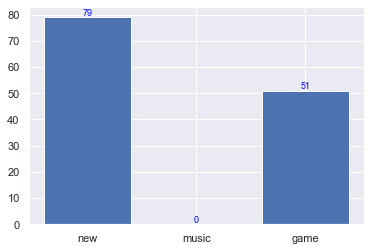

In [50]:
x = ['new', 'music', 'game']
y = [79, 0, 51]

plt.bar(x, y)
for i, v in enumerate(x):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='blue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

plt.show()